In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from three_step_classification import ThreeStepClassifier

In [2]:
import IPython

%load_ext autoreload
%autoreload 2

In [3]:
def load_model(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        return joblib.load(file_path)
    else:
        print(f"Model file '{file_path}' does not exist.")
        return None

In [136]:

from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, balanced_accuracy_score
from matplotlib import pyplot
def plot_precision_recall(model, X, y):
    yhat = model.predict_proba(X)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(y, yhat)
    # convert to f score
    f1score = (2 * precision * recall) / (precision + recall)
    pr_auc = average_precision_score(y, yhat)
    
    fhalfscore = ((5/4) * (precision * recall)) / (precision / 4 + recall)
    y_pred = np.zeros(len(y))
    
    # locate the index of the largest f score
    ix = argmax(f1score)
    
    y_pred[yhat > thresholds[ix]] = 1
    balanced_accuracy = balanced_accuracy_score(y, y_pred)
    print('Best Threshold=%f, F1-Score=%.3f, PR-AUC=%.3f, FHalf-Score=%.3f, BalancedAcc=%.3f' % (thresholds[ix], f1score[ix], pr_auc, fhalfscore[ix], balanced_accuracy))
    # plot the roc curve for the model
    no_skill = len(y[y==1]) / len(y)
    pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    # show the plot
    pyplot.show()

In [147]:
def plot_points_oof(df_labeled, df_unlabeled, feature1, feature2):
    df_unlabeled_oof = df_unlabeled[df_unlabeled['Labels'] == "oof"]
    df_unlabeled_if = df_unlabeled[df_unlabeled['Labels'] != "oof"]
    df_labeled_oof = df_labeled[df_labeled['Labels'] == "oof"]
    df_labeled_if = df_labeled[df_labeled['Labels'] != "oof"]
    # Set up the plot
    fig, ax = plt.subplots()
    
    # Plot labeled points
    ax.scatter(df_unlabeled_oof[feature1], df_unlabeled_oof[feature2],
               color='red', marker='x', alpha=0.2, label='Unlabeled Out of Focus')
    ax.scatter(df_unlabeled_if[feature1], df_unlabeled_if[feature2],
               color='lightgreen', marker='x', alpha=0.2, label='Unlabeled In Focus')
    
    
    ax.scatter(df_labeled_if[feature1], df_labeled_if[feature2],
               color='darkgreen', label='Labeled In Focus')
    ax.scatter(df_labeled_oof[feature1], df_labeled_oof[feature2],
               color='darkred', label='Labeled Out of Focus')
    # Plot unlabeled points
    # Set plot title and labels
    ax.set_title('Scatter Plot')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.show()

In [146]:
def plot_points_agg(df_labeled, df_unlabeled, feature1, feature2):
    df_unlabeled_oof = df_unlabeled[df_unlabeled['Labels'] == "agg"]
    df_unlabeled_if = df_unlabeled[df_unlabeled['Labels'] != "agg"]
    df_labeled_oof = df_labeled[df_labeled['Labels'] == "agg"]
    df_labeled_if = df_labeled[df_labeled['Labels'] != "agg"]
    # Set up the plot
    fig, ax = plt.subplots()
    
    # Plot labeled points
    ax.scatter(df_unlabeled_oof[feature1], df_unlabeled_oof[feature2],
               color='red', marker='x', alpha=0.2, label='Unlabeled Aggregate')
    ax.scatter(df_unlabeled_if[feature1], df_unlabeled_if[feature2],
               color='lightgreen', marker='x', alpha=0.2, label='Unlabeled Single Cell')
    
    
    ax.scatter(df_labeled_if[feature1], df_labeled_if[feature2],
               color='darkgreen', label='Labeled Single Cell')
    ax.scatter(df_labeled_oof[feature1], df_labeled_oof[feature2],
               color='darkred', label='Labeled Aggregate')
    # Plot unlabeled points
    # Set plot title and labels
    ax.set_title('Scatter Plot')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.show()

# LogisticRegression OOF

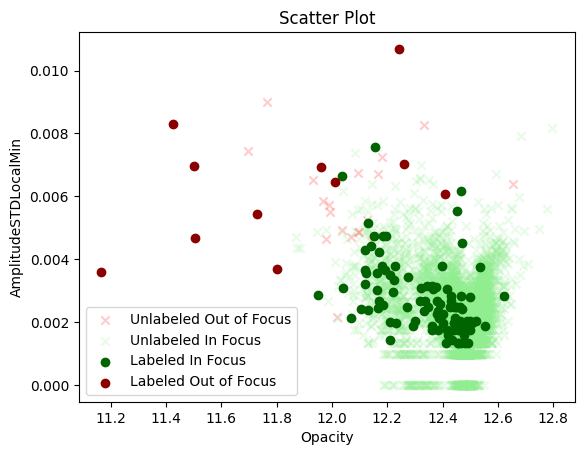

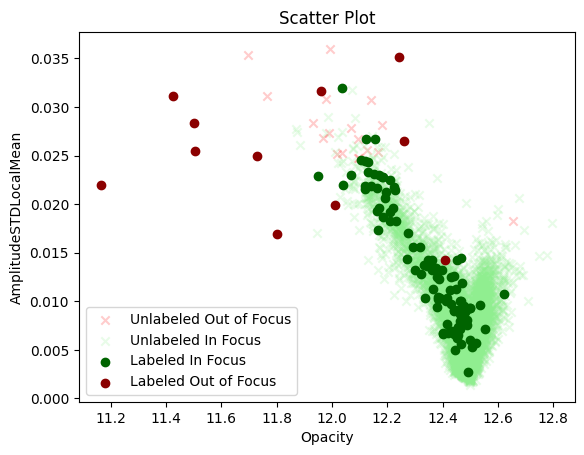

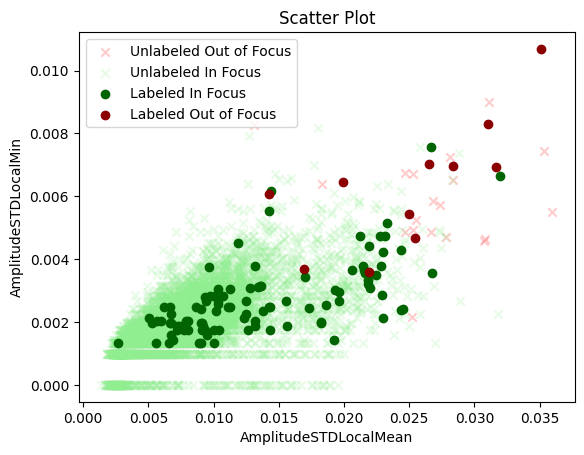

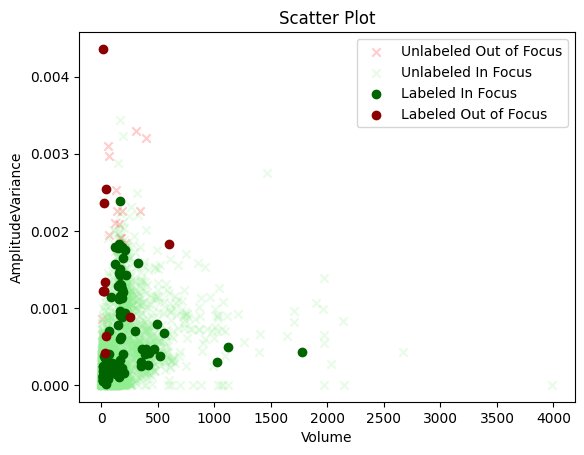

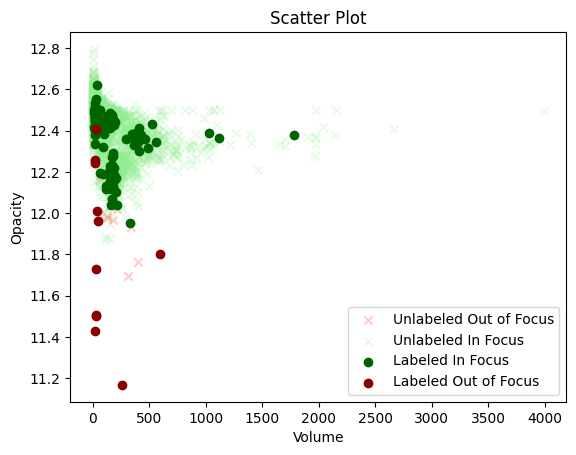

In [42]:
loaded_oof_model = load_model("models", "oof_logreg_fhalf.pkl")

df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

df = loaded_oof_model.predict(df_unlabeled.drop(["Mask ID", "Image ID"], axis=1))
# Mapping dictionary
label_mapping = {1: 'oof', 0: 'infocus'}

# Transforming labels
categorical_labels = [label_mapping[label] for label in df]
df_unlabeled['Labels'] = categorical_labels

plot_points_oof(df_labeled, df_unlabeled, 'Opacity', 'AmplitudeSTDLocalMin')
plot_points_oof(df_labeled, df_unlabeled, 'Opacity', 'AmplitudeSTDLocalMean')
plot_points_oof(df_labeled, df_unlabeled, 'AmplitudeSTDLocalMean', 'AmplitudeSTDLocalMin')
plot_points_oof(df_labeled, df_unlabeled, 'Volume', 'AmplitudeVariance')
plot_points_oof(df_labeled, df_unlabeled, 'Volume', 'Opacity')

In [43]:
from sklearn.metrics import roc_curve

X_train, X_test, y_train, y_test = train_test_split(df_labeled.drop('Labels', axis=1), df_labeled['Labels'], test_size=0.25, random_state=22, stratify=df_labeled['Labels'])

In [44]:
yhat = loaded_oof_model.predict_proba(X_test)
y_train_binary = np.where(y_train == 'oof', 1, 0)
y_test_binary = np.where(y_test == 'oof', 1, 0)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

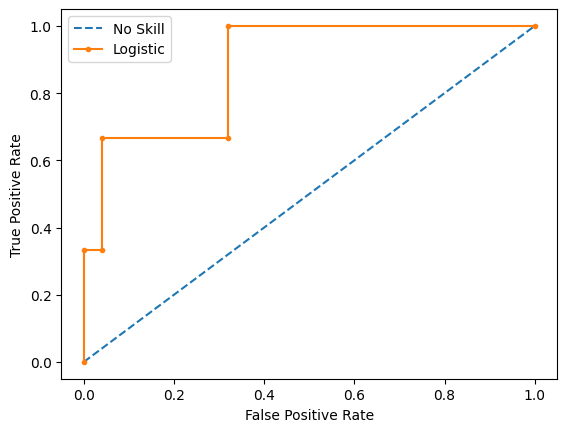

In [45]:
import matplotlib.pyplot as plt

# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test_binary, pos_probs)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

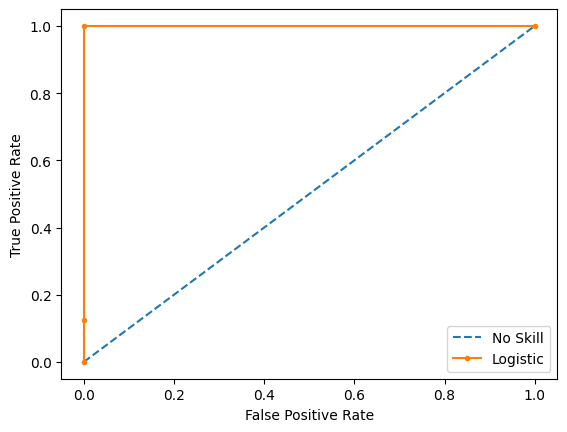

In [46]:
yhat_train = loaded_oof_model.predict_proba(X_train)
# retrieve just the probabilities for the positive class
pos_probs_train = yhat_train[:, 1]

# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_train_binary, pos_probs_train)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Counter({0: 25, 1: 3})


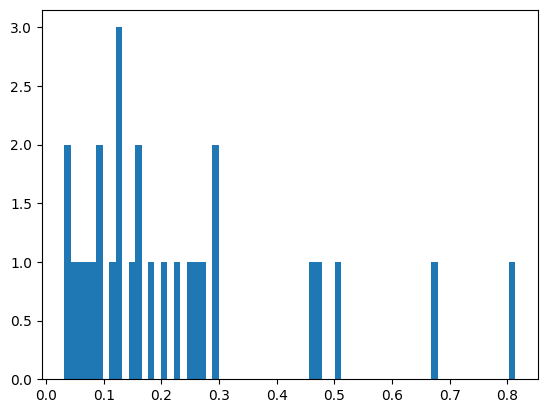

In [47]:
# summarize the distribution of predicted probabilities
from collections import Counter
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# predict probabilities
yhat = loaded_oof_model.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# predict class labels
yhat = loaded_oof_model.predict(X_test)
# summarize the distribution of class labels
print(Counter(yhat))
# create a histogram of the predicted probabilities
pyplot.hist(pos_probs, bins=70)
pyplot.show()

In [48]:
print(Counter(y_test_binary))

Counter({0: 25, 1: 3})


In [49]:
pos_probs[pos_probs > 0.35]

array([0.67064573, 0.47720927, 0.4658734 , 0.50306056, 0.81334726])

Best Threshold=0.892055, F1-Score=0.750, PR-AUC=0.728, FHalf-Score=0.882, BalancedAcc=0.700


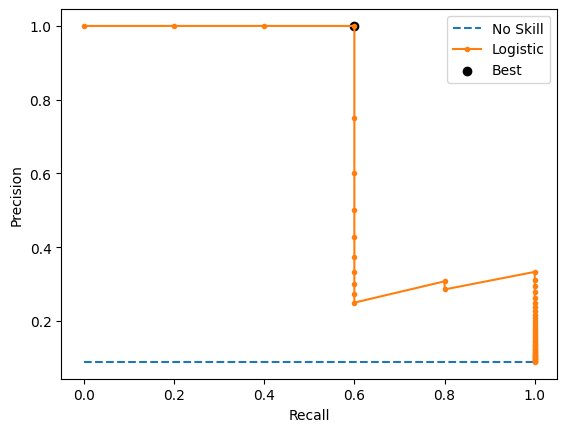

Best Threshold=0.692268, F1-Score=0.750, PR-AUC=0.739, FHalf-Score=0.882, BalancedAcc=0.700


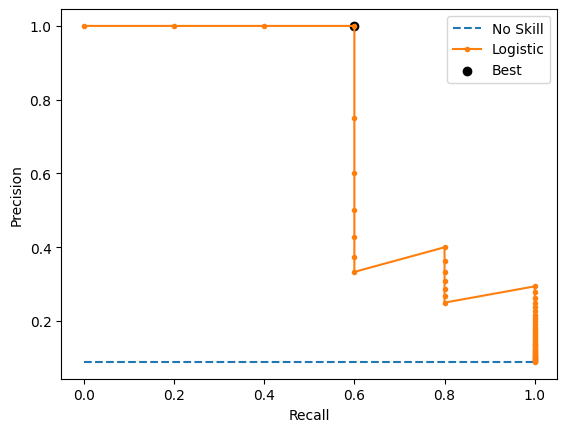

In [172]:
from sklearn.metrics import roc_curve
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

X_train, X_test, y_train, y_test = train_test_split(df_labeled.drop('Labels', axis=1), df_labeled['Labels'],
                                                    test_size=0.5, random_state=43, stratify=df_labeled['Labels'])
y_train_binary = np.where(y_train == 'oof', 1, 0)
y_test_binary = np.where(y_test == 'oof', 1, 0)

loaded_oof_model_logreg_fhalf = load_model("models", "oof_logreg_fhalf.pkl")
loaded_oof_model_logreg_fhalf.fit(X_train, y_train_binary)
loaded_oof_model_logreg_prauc = load_model("models", "oof_logreg_prauc.pkl")
loaded_oof_model_logreg_prauc.fit(X_train, y_train_binary)

plot_precision_recall(loaded_oof_model_logreg_fhalf, X_test, y_test_binary)
plot_precision_recall(loaded_oof_model_logreg_prauc, X_test, y_test_binary)

Counter({'infocus': 7808, 'oof': 17})


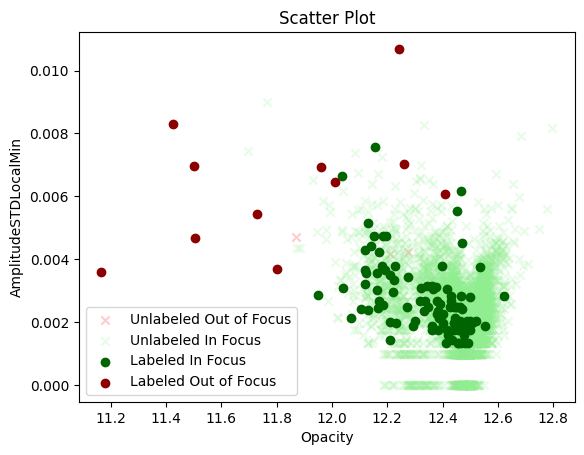

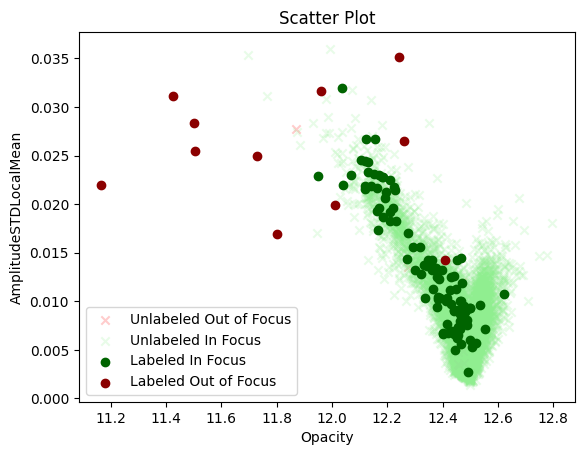

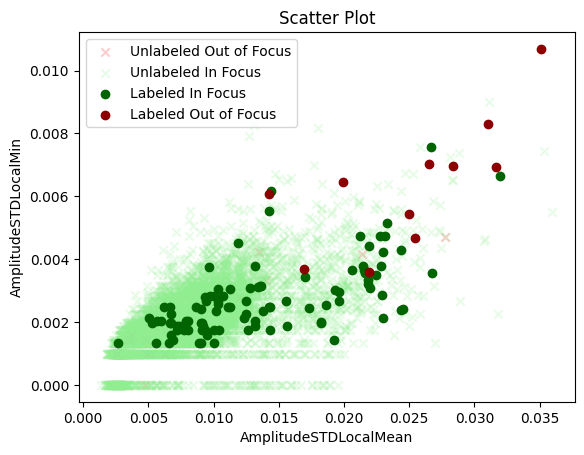

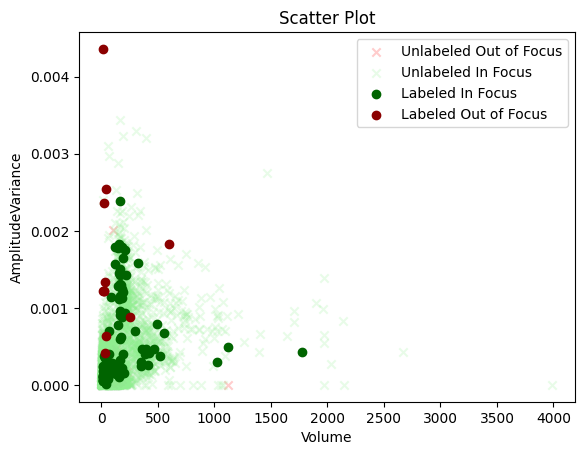

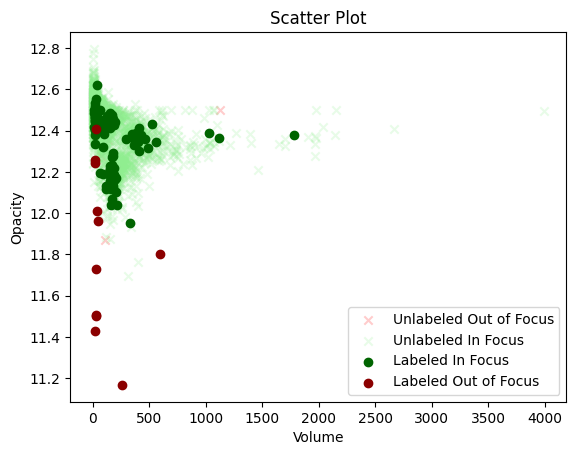

In [133]:
loaded_oof_model_logreg_fhalf = load_model("models", "oof_logreg_fhalf.pkl")

df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

X_train = df_labeled.drop('Labels', axis=1)
y_train = df_labeled['Labels']

y_train_binary = np.where(y_train == 'oof', 1, 0)

loaded_oof_model_logreg_fhalf.fit(X_train, y_train_binary)

y_pred_proba = loaded_oof_model_logreg_fhalf.predict_proba(df_unlabeled.drop(["Mask ID", "Image ID"], axis=1))

optimal_threshold = 0.908240
y_pred_mask = y_pred_proba[:,1] > optimal_threshold
y_pred = np.zeros(len(y_pred_proba))
y_pred[y_pred_mask] = 1
# Mapping dictionary
label_mapping = {1: 'oof', 0: 'infocus'}

# Transforming labels
categorical_labels = [label_mapping[label] for label in y_pred]
df_unlabeled['Labels'] = categorical_labels
print(Counter(df_unlabeled['Labels']))

plot_points_oof(df_labeled, df_unlabeled, 'Opacity', 'AmplitudeSTDLocalMin')
plot_points_oof(df_labeled, df_unlabeled, 'Opacity', 'AmplitudeSTDLocalMean')
plot_points_oof(df_labeled, df_unlabeled, 'AmplitudeSTDLocalMean', 'AmplitudeSTDLocalMin')
plot_points_oof(df_labeled, df_unlabeled, 'Volume', 'AmplitudeVariance')
plot_points_oof(df_labeled, df_unlabeled, 'Volume', 'Opacity')

# XGBoost OOF

In [84]:
loaded_oof_model_xgb = load_model("models", "oof_xgb_fhalf.pkl")

In [85]:
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

df = loaded_oof_model_xgb.predict(df_unlabeled.drop(["Mask ID", "Image ID"], axis=1))

# Mapping dictionary
label_mapping = {1: 'oof', 0: 'infocus'}

# Transforming labels
categorical_labels = [label_mapping[label] for label in df]
df_unlabeled['Labels'] = categorical_labels

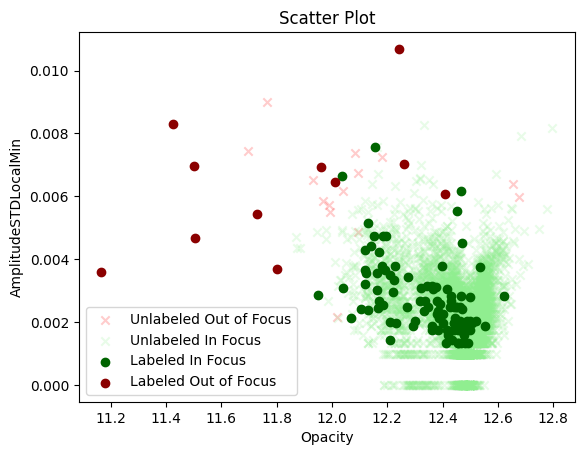

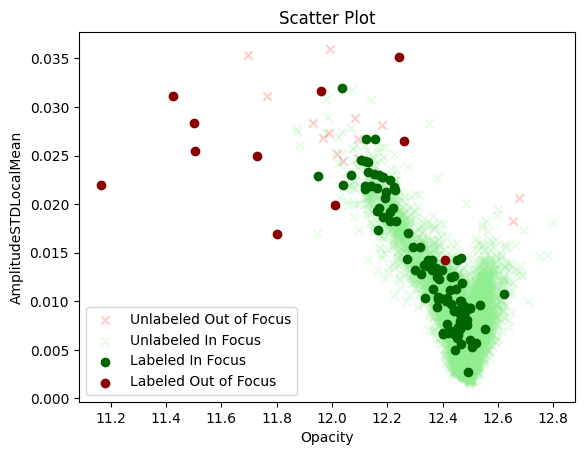

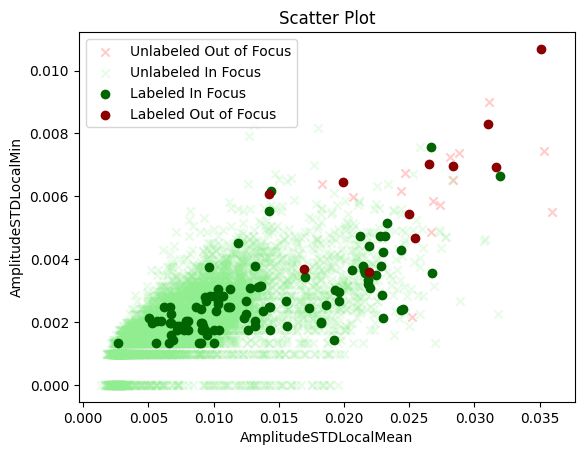

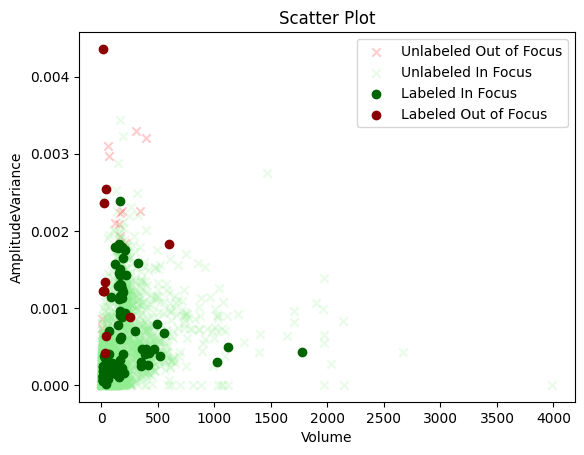

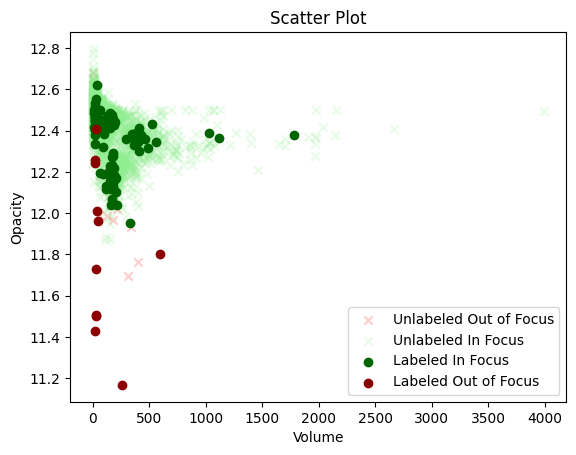

In [86]:
plot_points_oof(df_labeled, df_unlabeled, 'Opacity', 'AmplitudeSTDLocalMin')
plot_points_oof(df_labeled, df_unlabeled, 'Opacity', 'AmplitudeSTDLocalMean')
plot_points_oof(df_labeled, df_unlabeled, 'AmplitudeSTDLocalMean', 'AmplitudeSTDLocalMin')
plot_points_oof(df_labeled, df_unlabeled, 'Volume', 'AmplitudeVariance')
plot_points_oof(df_labeled, df_unlabeled, 'Volume', 'Opacity')

In [95]:
from sklearn.metrics import roc_curve

X_train, X_test, y_train, y_test = train_test_split(df_labeled.drop('Labels', axis=1), df_labeled['Labels'], test_size=0.25, random_state=22, stratify=df_labeled['Labels'])

In [96]:
yhat = loaded_oof_model_xgb.predict_proba(X_test)
y_train_binary = np.where(y_train == 'oof', 1, 0)
y_test_binary = np.where(y_test == 'oof', 1, 0)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

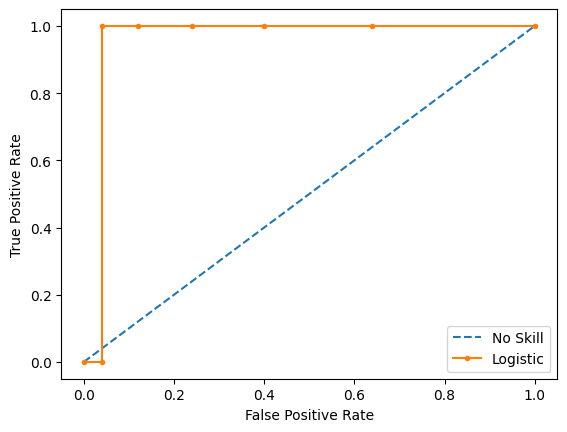

Best Threshold=0.126809


In [97]:
import matplotlib.pyplot as plt

# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, thresholds = roc_curve(y_test_binary, pos_probs)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Counter({0: 27, 1: 1})


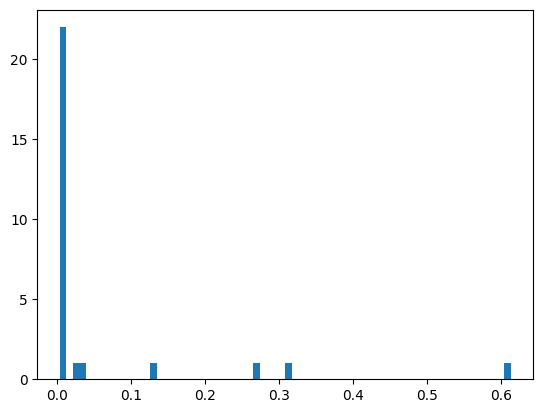

In [98]:
# summarize the distribution of predicted probabilities
from collections import Counter
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# predict probabilities
yhat = loaded_oof_model_xgb.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# predict class labels
yhat = loaded_oof_model_xgb.predict(X_test)
# summarize the distribution of class labels
print(Counter(yhat))
# create a histogram of the predicted probabilities
pyplot.hist(pos_probs, bins=70)
pyplot.show()

Counter({0: 7811, 1: 14})


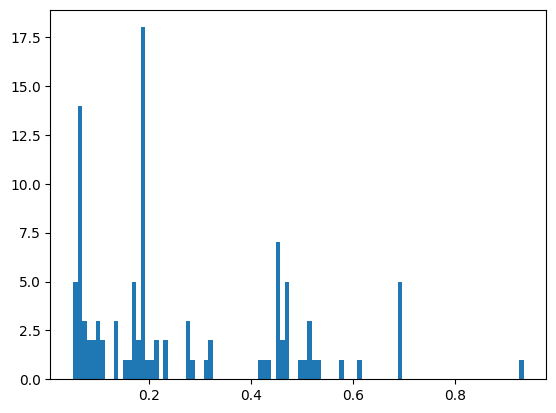

In [99]:
X_unlabeled = df_unlabeled.drop(["Labels", "Mask ID", "Image ID"], axis=1)
# summarize the distribution of predicted probabilities
from collections import Counter
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# predict probabilities
yhat = loaded_oof_model_xgb.predict_proba(X_unlabeled)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# predict class labels
yhat = loaded_oof_model_xgb.predict(X_unlabeled)
# summarize the distribution of class labels
print(Counter(yhat))
# create a histogram of the predicted probabilities
pyplot.hist(pos_probs[pos_probs > 0.05], bins=100)
pyplot.show()

Best Threshold=0.026712, F1-Score=0.667, PR-AUC=0.698, FHalf-Score=0.556, BalancedAcc=0.851


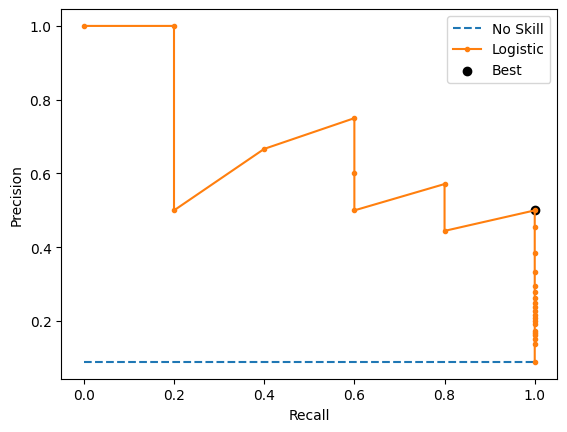

Best Threshold=0.029103, F1-Score=0.667, PR-AUC=0.764, FHalf-Score=0.556, BalancedAcc=0.851


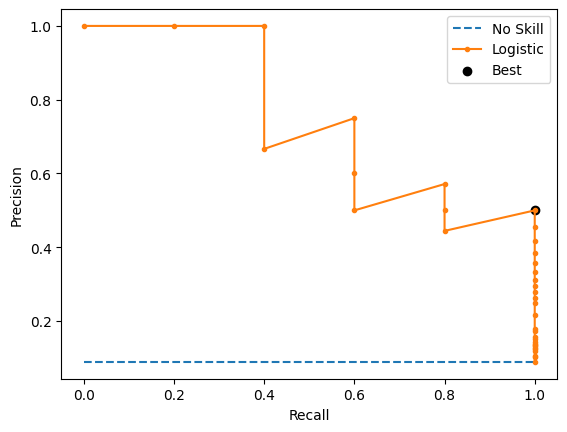

In [173]:
from sklearn.metrics import roc_curve
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

df = loaded_oof_model_xgb.predict(df_unlabeled.drop(["Mask ID", "Image ID"], axis=1))

# Mapping dictionary
label_mapping = {1: 'oof', 0: 'infocus'}

# Transforming labels
categorical_labels = [label_mapping[label] for label in df]
df_unlabeled['Labels'] = categorical_labels
X_train, X_test, y_train, y_test = train_test_split(df_labeled.drop('Labels', axis=1), df_labeled['Labels'],
                                                    test_size=0.5, random_state=43, stratify=df_labeled['Labels'])
y_train_binary = np.where(y_train == 'oof', 1, 0)
y_test_binary = np.where(y_test == 'oof', 1, 0)

loaded_oof_model_xgb_fhalf = load_model("models", "oof_xgb_fhalf.pkl")
loaded_oof_model_xgb_fhalf.fit(X_train, y_train_binary)
loaded_oof_model_xgb_prauc = load_model("models", "oof_xgb_prauc.pkl")
loaded_oof_model_xgb_prauc.fit(X_train, y_train_binary)

plot_precision_recall(loaded_oof_model_xgb_fhalf, X_test, y_test_binary)
plot_precision_recall(loaded_oof_model_xgb_prauc, X_test, y_test_binary)

Counter({'infocus': 7784, 'oof': 41})


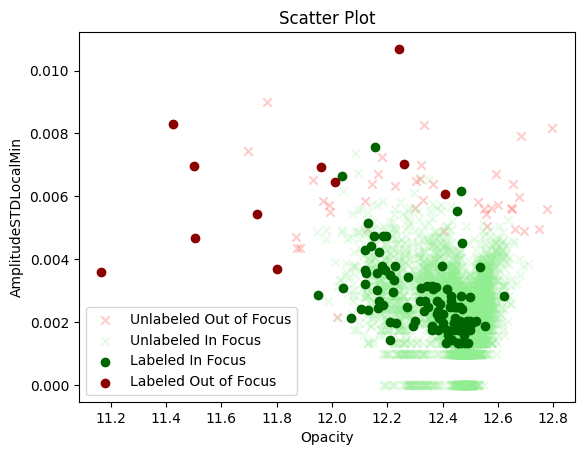

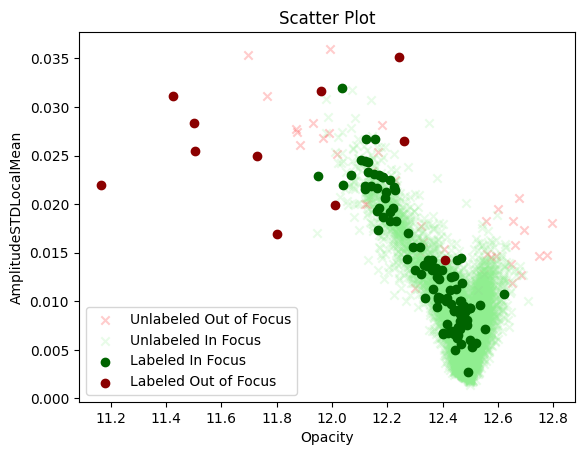

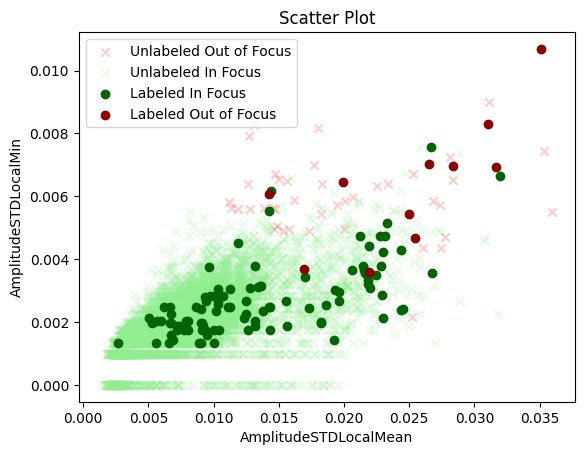

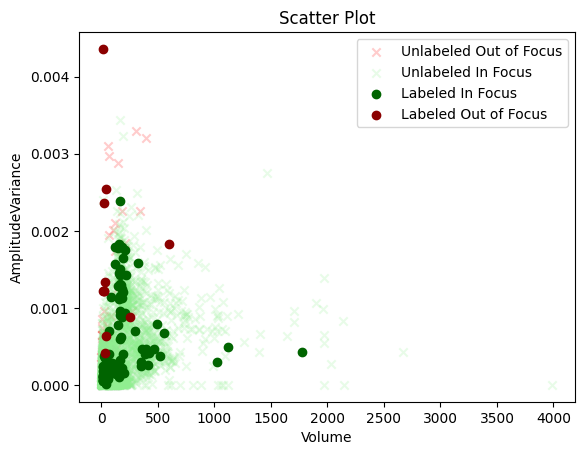

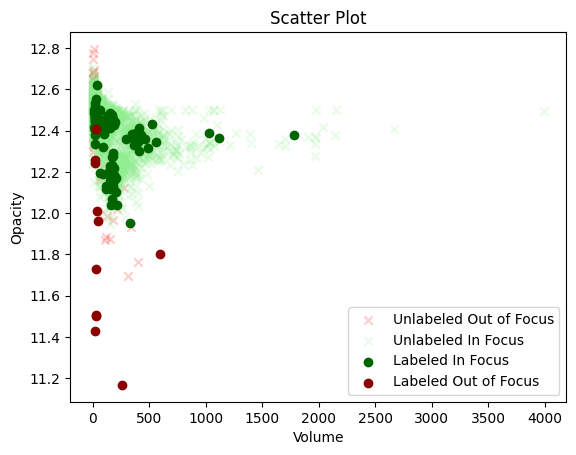

In [128]:
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

X_train = df_labeled.drop('Labels', axis=1)
y_train = df_labeled['Labels']

y_train_binary = np.where(y_train == 'oof', 1, 0)

loaded_oof_model_xgb_fhalf.fit(X_train, y_train_binary)

y_pred_proba = loaded_oof_model_xgb_fhalf.predict_proba(df_unlabeled.drop(["Mask ID", "Image ID"], axis=1))

optimal_threshold = 0.276546
y_pred_mask = y_pred_proba[:,1] > optimal_threshold
y_pred = np.zeros(len(y_pred_proba))
y_pred[y_pred_mask] = 1
# Mapping dictionary
label_mapping = {1: 'oof', 0: 'infocus'}

# Transforming labels
categorical_labels = [label_mapping[label] for label in y_pred]
df_unlabeled['Labels'] = categorical_labels
print(Counter(df_unlabeled['Labels']))

plot_points_oof(df_labeled, df_unlabeled, 'Opacity', 'AmplitudeSTDLocalMin')
plot_points_oof(df_labeled, df_unlabeled, 'Opacity', 'AmplitudeSTDLocalMean')
plot_points_oof(df_labeled, df_unlabeled, 'AmplitudeSTDLocalMean', 'AmplitudeSTDLocalMin')
plot_points_oof(df_labeled, df_unlabeled, 'Volume', 'AmplitudeVariance')
plot_points_oof(df_labeled, df_unlabeled, 'Volume', 'Opacity')

# Logistic Regression AGG

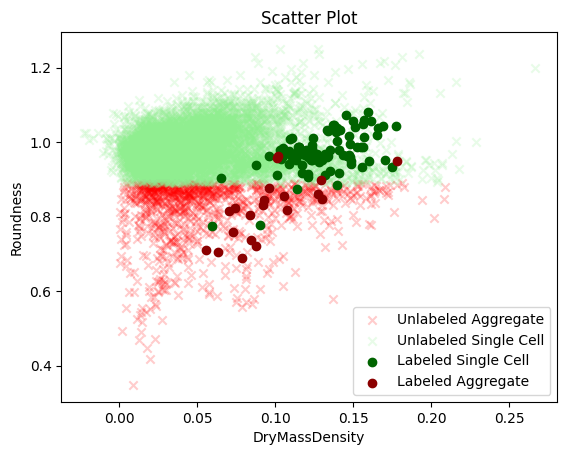

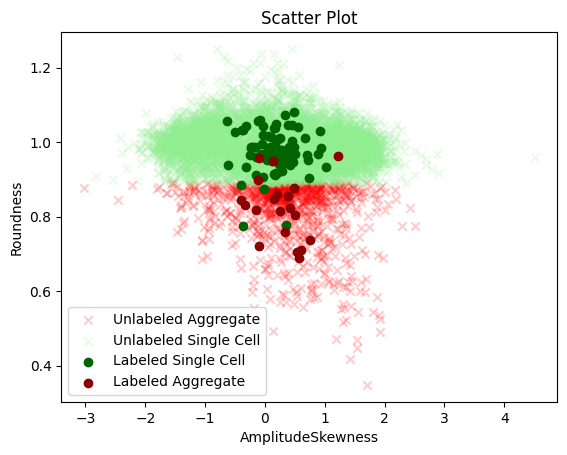

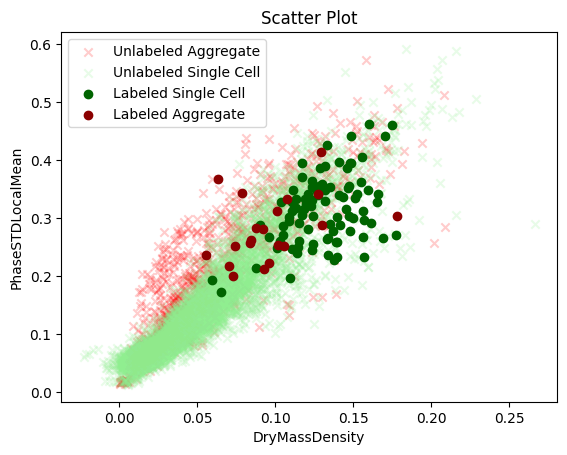

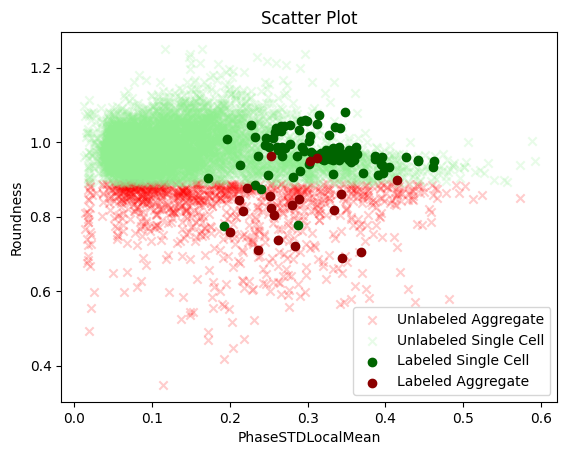

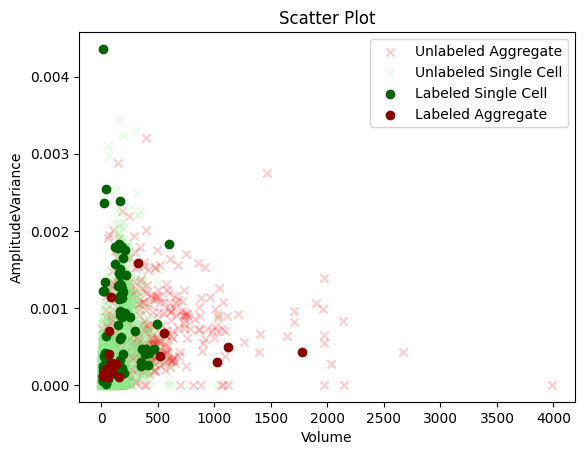

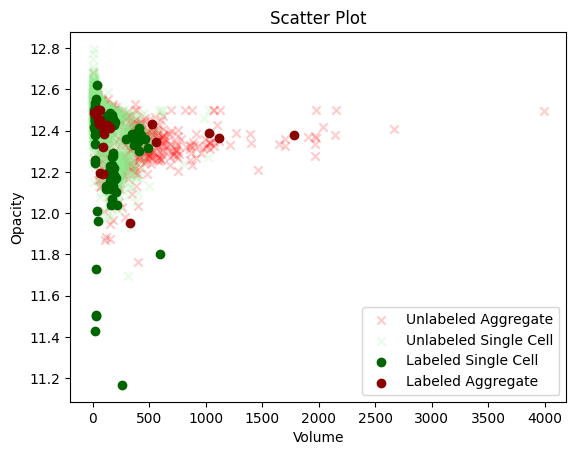

In [157]:
loaded_agg_model = load_model("models", "agg_logreg_prauc.pkl")

df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

df = loaded_agg_model.predict(df_unlabeled.drop(["Mask ID", "Image ID"], axis=1))
# Mapping dictionary
label_mapping = {1: 'agg', 0: 'single'}

# Transforming labels
categorical_labels = [label_mapping[label] for label in df]
df_unlabeled['Labels'] = categorical_labels

plot_points_agg(df_labeled, df_unlabeled, 'DryMassDensity', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'AmplitudeSkewness', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'DryMassDensity', 'PhaseSTDLocalMean')
plot_points_agg(df_labeled, df_unlabeled, 'PhaseSTDLocalMean', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'Volume', 'AmplitudeVariance')
plot_points_agg(df_labeled, df_unlabeled, 'Volume', 'Opacity')

Best Threshold=0.810357, F1-Score=0.900, PR-AUC=0.888, FHalf-Score=0.900, BalancedAcc=0.889


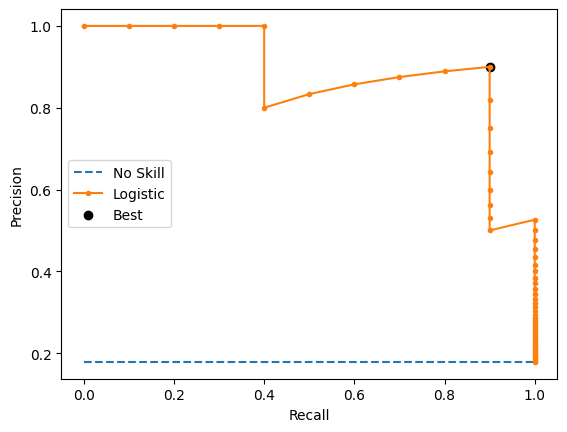

Best Threshold=0.502447, F1-Score=0.303, PR-AUC=0.179, FHalf-Score=0.214, BalancedAcc=0.500


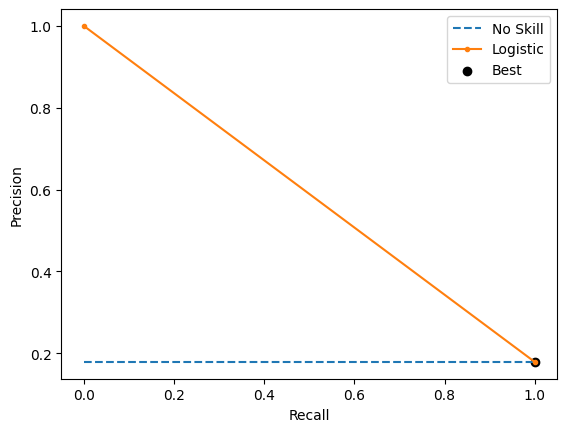

In [174]:
from sklearn.metrics import roc_curve
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

X_train, X_test, y_train, y_test = train_test_split(df_labeled.drop('Labels', axis=1), df_labeled['Labels'],
                                                    test_size=0.5, random_state=43, stratify=df_labeled['Labels'])
y_train_binary = np.where(y_train == 'agg', 1, 0)
y_test_binary = np.where(y_test == 'agg', 1, 0)

loaded_agg_model_logreg_fhalf = load_model("models", "agg_logreg_fhalf.pkl")
loaded_agg_model_logreg_fhalf.fit(X_train, y_train_binary)
loaded_agg_model_logreg_prauc = load_model("models", "agg_logreg_prauc.pkl")
loaded_agg_model_logreg_prauc.fit(X_train, y_train_binary)

plot_precision_recall(loaded_agg_model_logreg_fhalf, X_test, y_test_binary)
plot_precision_recall(loaded_agg_model_logreg_prauc, X_test, y_test_binary)

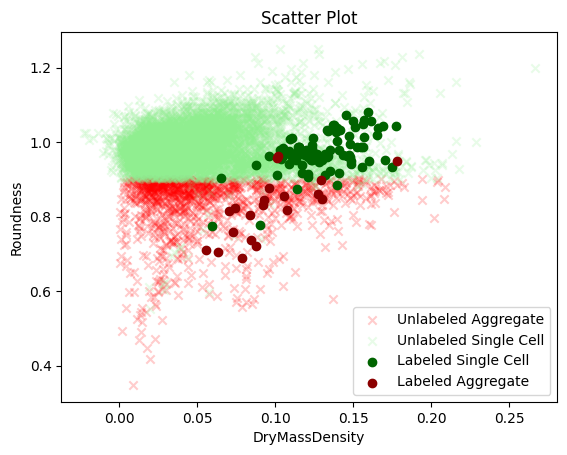

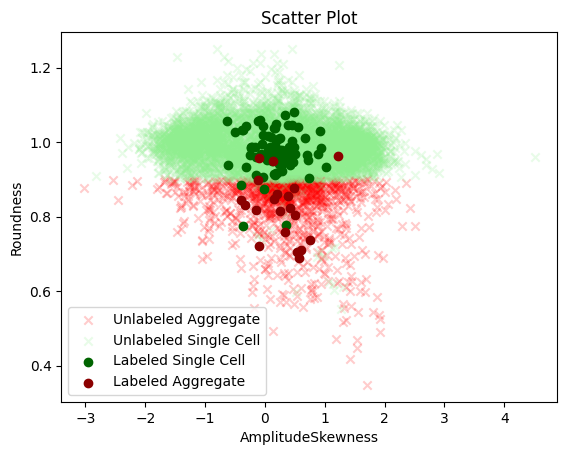

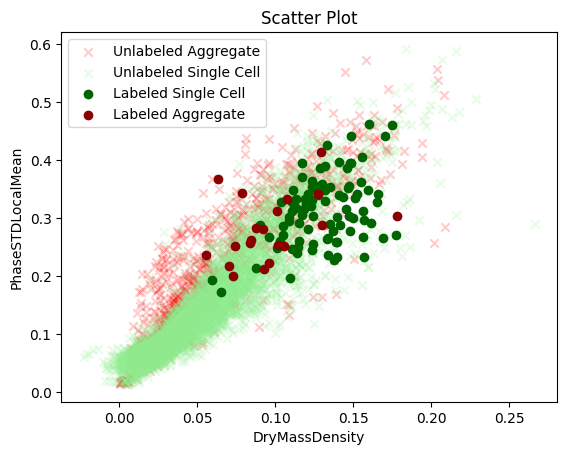

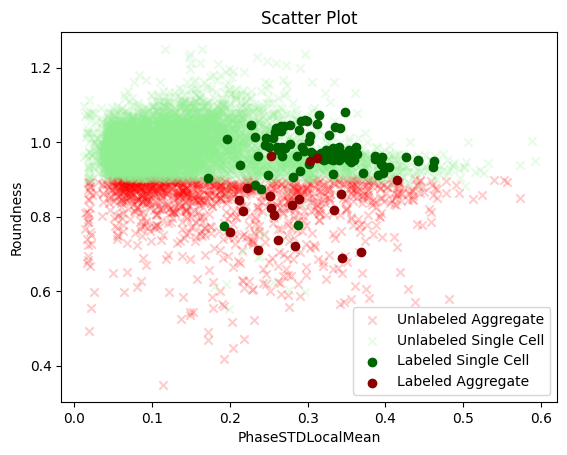

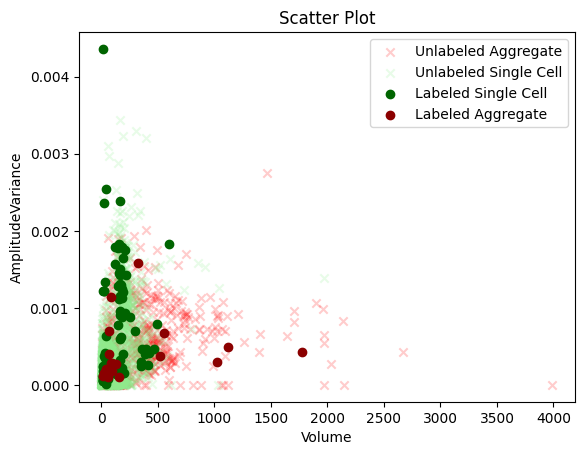

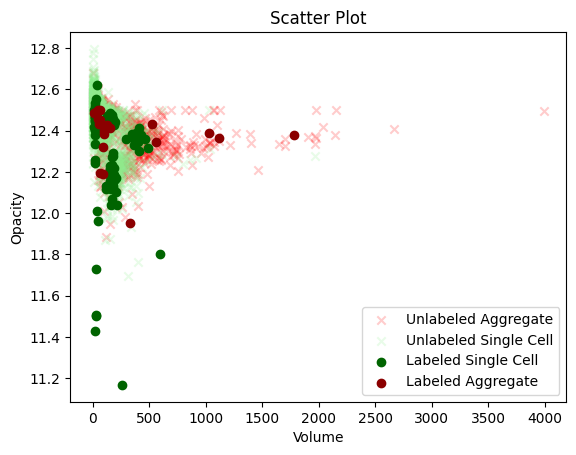

In [175]:
loaded_agg_model = load_model("models", "agg_xbg_prauc.pkl")

df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

df = loaded_agg_model.predict(df_unlabeled.drop(["Mask ID", "Image ID"], axis=1))
# Mapping dictionary
label_mapping = {1: 'agg', 0: 'single'}

# Transforming labels
categorical_labels = [label_mapping[label] for label in df]
df_unlabeled['Labels'] = categorical_labels

plot_points_agg(df_labeled, df_unlabeled, 'DryMassDensity', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'AmplitudeSkewness', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'DryMassDensity', 'PhaseSTDLocalMean')
plot_points_agg(df_labeled, df_unlabeled, 'PhaseSTDLocalMean', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'Volume', 'AmplitudeVariance')
plot_points_agg(df_labeled, df_unlabeled, 'Volume', 'Opacity')

Best Threshold=0.545215, F1-Score=0.900, PR-AUC=0.908, FHalf-Score=0.900, BalancedAcc=0.889


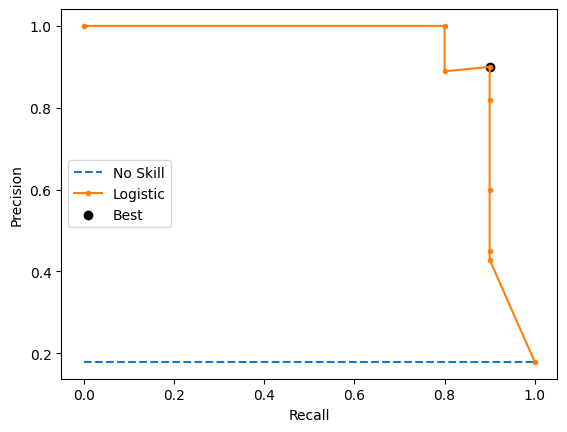

Best Threshold=0.965286, F1-Score=0.889, PR-AUC=0.917, FHalf-Score=0.952, BalancedAcc=0.850


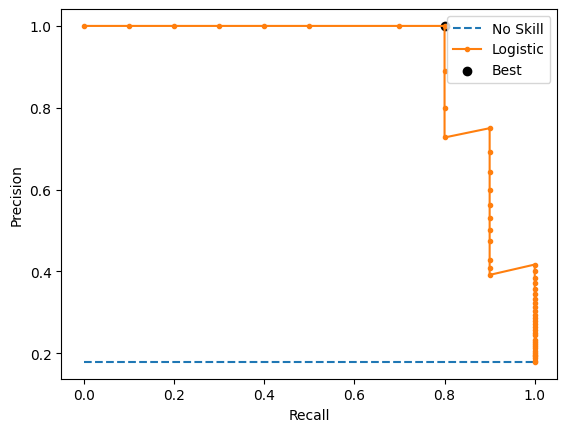

In [176]:
from sklearn.metrics import roc_curve
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

X_train, X_test, y_train, y_test = train_test_split(df_labeled.drop('Labels', axis=1), df_labeled['Labels'],
                                                    test_size=0.5, random_state=43, stratify=df_labeled['Labels'])
y_train_binary = np.where(y_train == 'agg', 1, 0)
y_test_binary = np.where(y_test == 'agg', 1, 0)

loaded_agg_model_xbg_fhalf = load_model("models", "agg_xbg_fhalf.pkl")
loaded_agg_model_xbg_fhalf.fit(X_train, y_train_binary)
loaded_agg_model_xbg_prauc = load_model("models", "agg_xbg_prauc.pkl")
loaded_agg_model_xbg_prauc.fit(X_train, y_train_binary)

plot_precision_recall(loaded_agg_model_xbg_fhalf, X_test, y_test_binary)
plot_precision_recall(loaded_agg_model_xbg_prauc, X_test, y_test_binary)

In [177]:
loaded_agg_model_xbg_fhalf

Pipeline(steps=[('column_transform', None), ('scaler', None),
                ('feature_selection', SelectKBest(k='all')),
                ('oversample', SMOTE(k_neighbors=3, random_state=42)),
                ('undersample', RandomUnderSampler(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=10,
                               n_jobs=None, nthread=1, num_parallel_tree=None,
                               predictor=None, ...))])

In [178]:
loaded_agg_model_xbg_prauc

Pipeline(steps=[('column_transform', None), ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()),
                ('oversample', SMOTE(k_neighbors=3, random_state=42)),
                ('undersample', RandomUnderSampler(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               e...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=500,
                               n_jobs=None, nthread=1, num_parallel_tree=None,
                               predictor=None, ...))])

Counter({'single': 6780, 'agg': 1045})


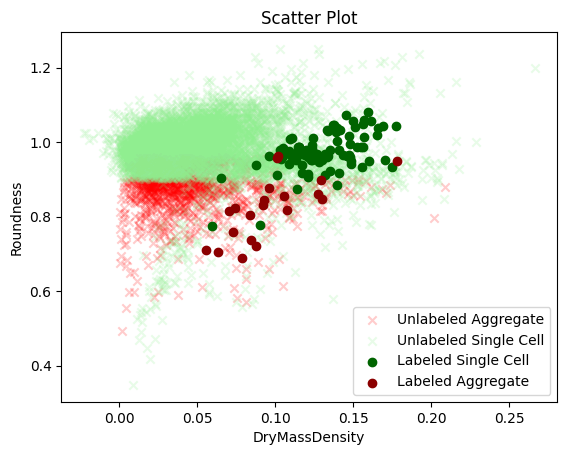

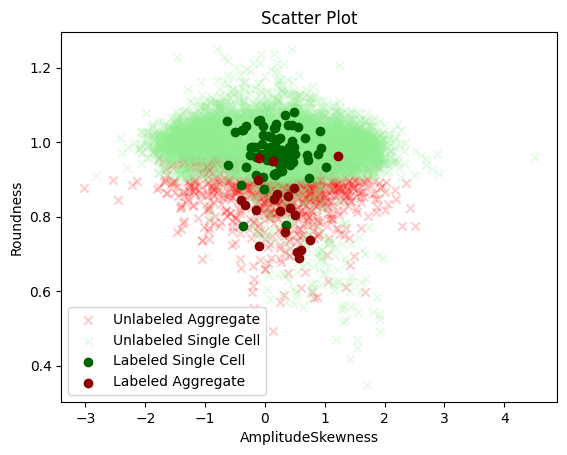

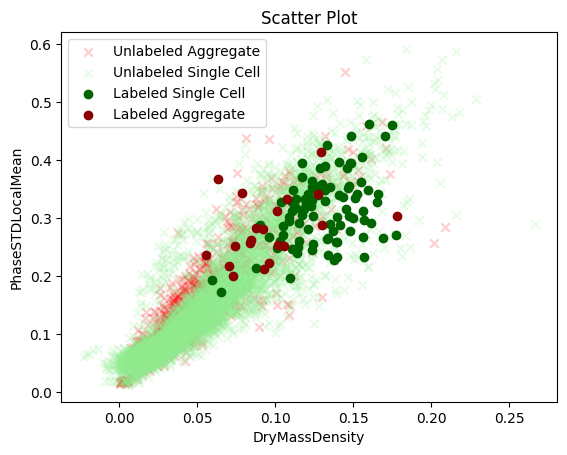

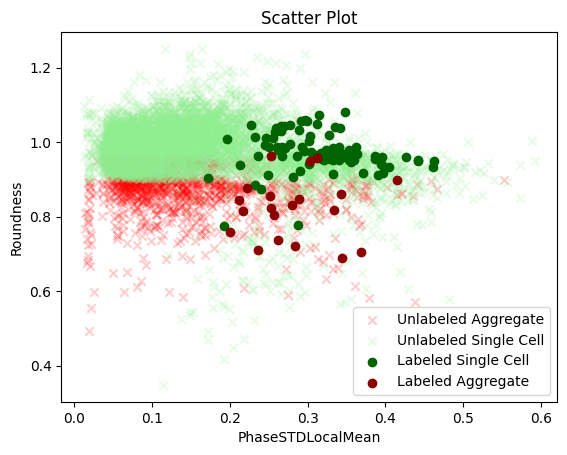

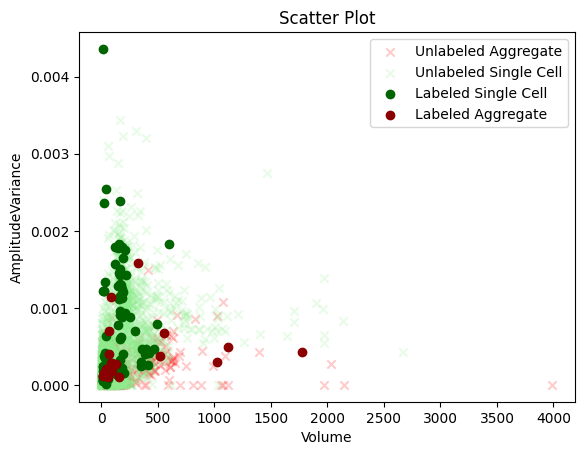

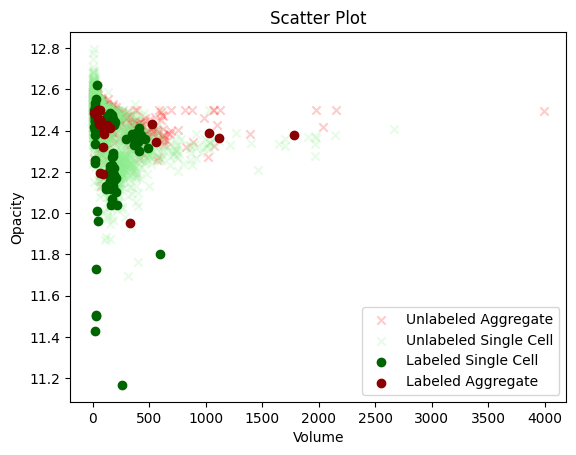

In [180]:
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

X_train = df_labeled.drop('Labels', axis=1)
y_train = df_labeled['Labels']

y_train_binary = np.where(y_train == 'agg', 1, 0)

loaded_oof_model_xgb_prauc.fit(X_train, y_train_binary)

y_pred_proba = loaded_oof_model_xgb_prauc.predict_proba(df_unlabeled.drop(["Mask ID", "Image ID"], axis=1))

optimal_threshold = 0.965286
y_pred_mask = y_pred_proba[:,1] > optimal_threshold
y_pred = np.zeros(len(y_pred_proba))
y_pred[y_pred_mask] = 1
# Mapping dictionary
label_mapping = {1: 'agg', 0: 'single'}

# Transforming labels
categorical_labels = [label_mapping[label] for label in y_pred]
df_unlabeled['Labels'] = categorical_labels
print(Counter(df_unlabeled['Labels']))

plot_points_agg(df_labeled, df_unlabeled, 'DryMassDensity', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'AmplitudeSkewness', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'DryMassDensity', 'PhaseSTDLocalMean')
plot_points_agg(df_labeled, df_unlabeled, 'PhaseSTDLocalMean', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'Volume', 'AmplitudeVariance')
plot_points_agg(df_labeled, df_unlabeled, 'Volume', 'Opacity')

Counter({'single': 4953, 'agg': 2872})


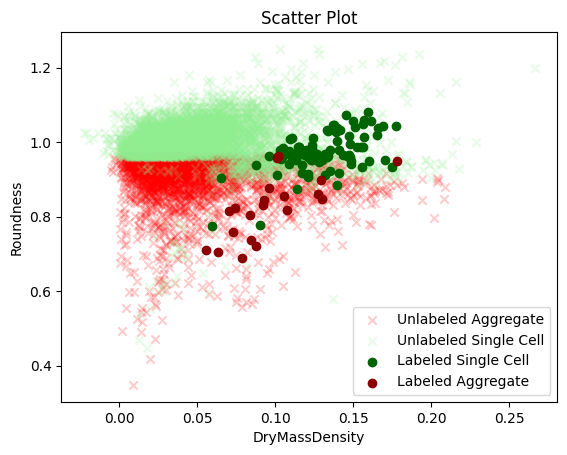

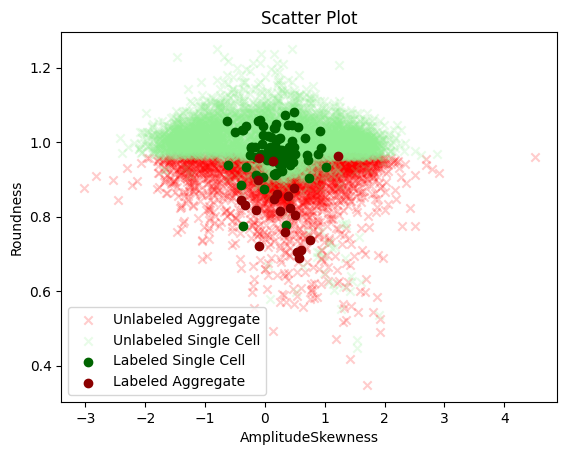

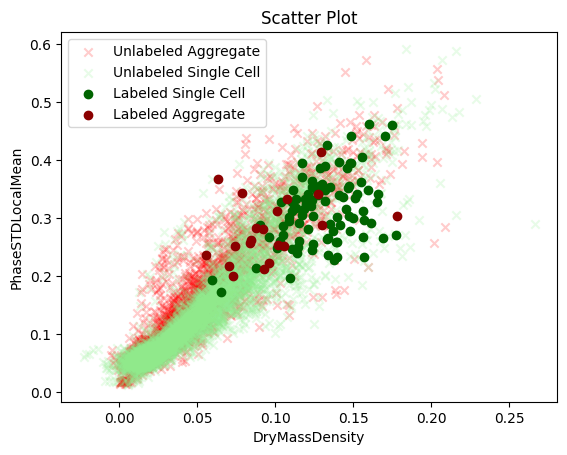

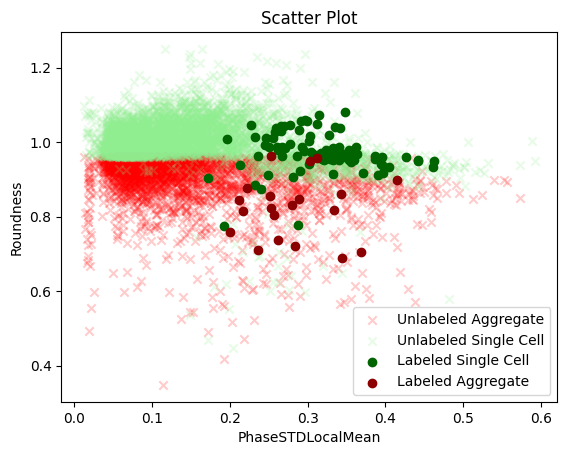

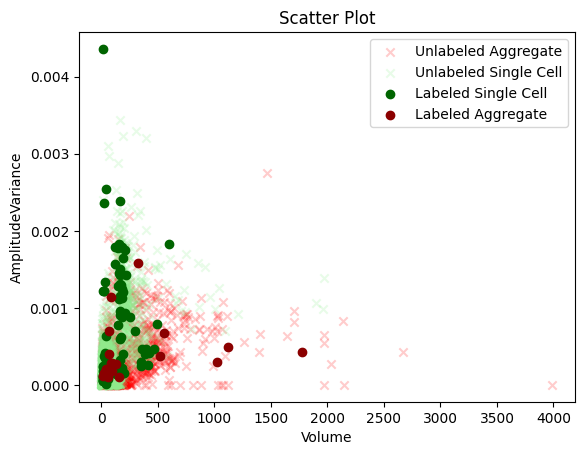

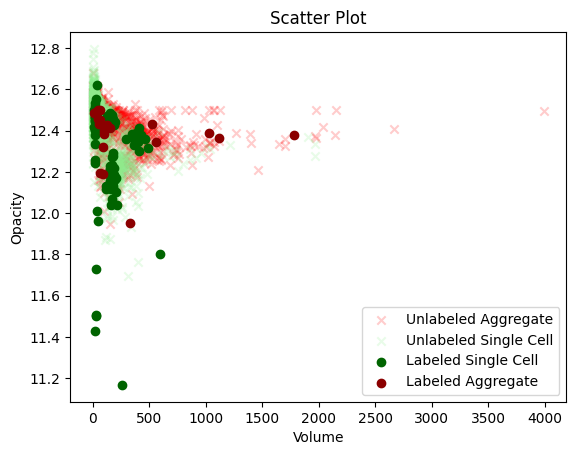

In [181]:
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

X_train = df_labeled.drop('Labels', axis=1)
y_train = df_labeled['Labels']

y_train_binary = np.where(y_train == 'agg', 1, 0)

loaded_oof_model_xgb_fhalf.fit(X_train, y_train_binary)

y_pred_proba = loaded_oof_model_xgb_fhalf.predict_proba(df_unlabeled.drop(["Mask ID", "Image ID"], axis=1))

optimal_threshold = 0.545215
y_pred_mask = y_pred_proba[:,1] > optimal_threshold
y_pred = np.zeros(len(y_pred_proba))
y_pred[y_pred_mask] = 1
# Mapping dictionary
label_mapping = {1: 'agg', 0: 'single'}

# Transforming labels
categorical_labels = [label_mapping[label] for label in y_pred]
df_unlabeled['Labels'] = categorical_labels
print(Counter(df_unlabeled['Labels']))

plot_points_agg(df_labeled, df_unlabeled, 'DryMassDensity', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'AmplitudeSkewness', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'DryMassDensity', 'PhaseSTDLocalMean')
plot_points_agg(df_labeled, df_unlabeled, 'PhaseSTDLocalMean', 'Roundness')
plot_points_agg(df_labeled, df_unlabeled, 'Volume', 'AmplitudeVariance')
plot_points_agg(df_labeled, df_unlabeled, 'Volume', 'Opacity')

Counter({0: 45, 1: 11})


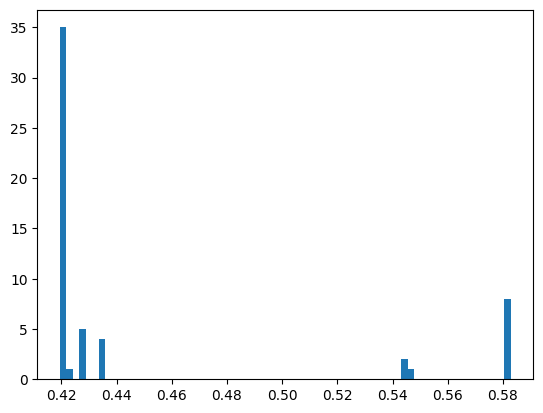

In [184]:
# summarize the distribution of predicted probabilities
from collections import Counter
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

X_train, X_test, y_train, y_test = train_test_split(df_labeled.drop('Labels', axis=1), df_labeled['Labels'],
                                                    test_size=0.5, random_state=43, stratify=df_labeled['Labels'])
y_train_binary = np.where(y_train == 'agg', 1, 0)
y_test_binary = np.where(y_test == 'agg', 1, 0)

loaded_agg_model_xbg_fhalf = load_model("models", "agg_xbg_fhalf.pkl")
loaded_agg_model_xbg_fhalf.fit(X_train, y_train_binary)
loaded_agg_model_xbg_prauc = load_model("models", "agg_xbg_prauc.pkl")
loaded_agg_model_xbg_prauc.fit(X_train, y_train_binary)

# predict probabilities
yhat = loaded_agg_model_xbg_fhalf.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# predict class labels
yhat = loaded_agg_model_xbg_fhalf.predict(X_test)
# summarize the distribution of class labels
print(Counter(yhat))
# create a histogram of the predicted probabilities
pyplot.hist(pos_probs, bins=70)
pyplot.show()

Counter({0: 42, 1: 14})


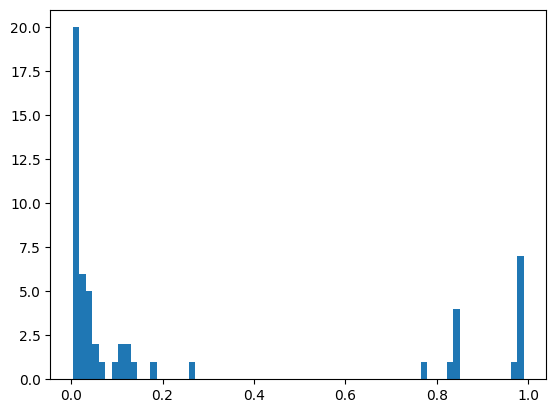

In [185]:
# predict probabilities
yhat = loaded_agg_model_xbg_prauc.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# predict class labels
yhat = loaded_agg_model_xbg_prauc.predict(X_test)
# summarize the distribution of class labels
print(Counter(yhat))
# create a histogram of the predicted probabilities
pyplot.hist(pos_probs, bins=70)
pyplot.show()


Classification Report Train Set:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.90      0.95        10

    accuracy                           0.98        55
   macro avg       0.99      0.95      0.97        55
weighted avg       0.98      0.98      0.98        55


Classification Report Test Set:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.82      0.90      0.86        10

    accuracy                           0.95        56
   macro avg       0.90      0.93      0.91        56
weighted avg       0.95      0.95      0.95        56



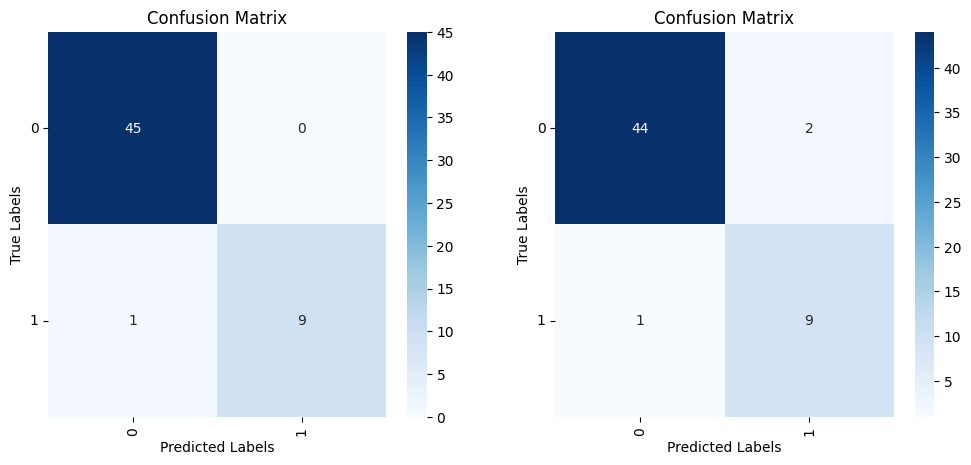


Classification Report Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        10

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55


Classification Report Test Set:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93        46
           1       0.64      0.90      0.75        10

    accuracy                           0.89        56
   macro avg       0.81      0.90      0.84        56
weighted avg       0.92      0.89      0.90        56



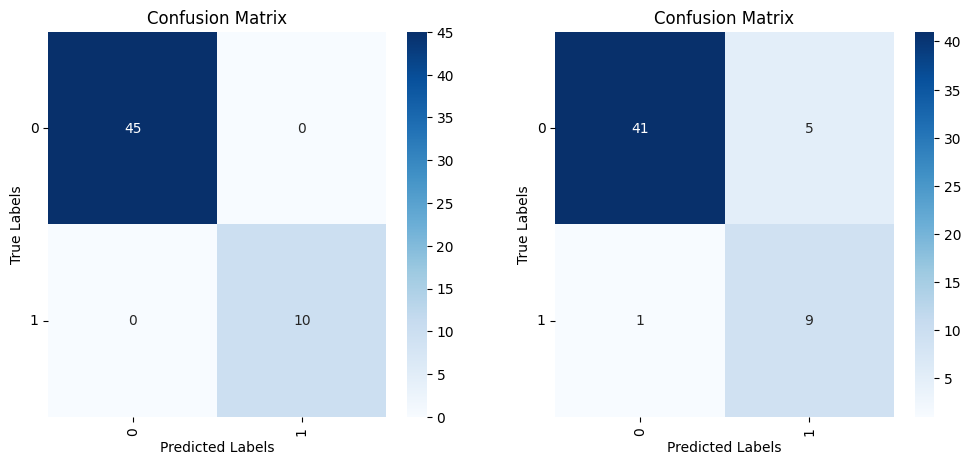

In [186]:
y_pred_test = loaded_agg_model_xbg_fhalf.predict(X_test)
y_pred_train = loaded_agg_model_xbg_fhalf.predict(X_train)

y_test_binary = np.where(y_test == 'agg', 1, 0)
confusion_mtx_train = confusion_matrix(y_train_binary, y_pred_train)
classification_rep_train = classification_report(y_train_binary, y_pred_train)

# Calculate confusion matrix and classification report
confusion_mtx = confusion_matrix(y_test_binary, y_pred_test)
classification_rep = classification_report(y_test_binary, y_pred_test)

# Print confusion matrix and classification report
print("\nClassification Report Train Set:")
print(classification_rep_train)
print("\nClassification Report Test Set:")
print(classification_rep)


# Create a figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot the confusion matrix heatmap
sns.heatmap(confusion_mtx_train, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title('Training Set')
# Plot the confusion matrix heatmap
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title('Test Set')

for i in range(2):
# Set labels, title, and ticks
    axs[i].set_xlabel('Predicted Labels')
    axs[i].set_ylabel('True Labels')
    axs[i].set_title('Confusion Matrix')
    axs[i].xaxis.set_ticklabels(np.unique(y_train_binary), rotation=90)
    axs[i].yaxis.set_ticklabels(np.unique(y_train_binary), rotation=0)

# Show the plot
plt.show()

y_pred_test = loaded_agg_model_xbg_prauc.predict(X_test)
y_pred_train = loaded_agg_model_xbg_prauc.predict(X_train)

y_test_binary = np.where(y_test == 'agg', 1, 0)
confusion_mtx_train = confusion_matrix(y_train_binary, y_pred_train)
classification_rep_train = classification_report(y_train_binary, y_pred_train)

# Calculate confusion matrix and classification report
confusion_mtx = confusion_matrix(y_test_binary, y_pred_test)
classification_rep = classification_report(y_test_binary, y_pred_test)

# Print confusion matrix and classification report
print("\nClassification Report Train Set:")
print(classification_rep_train)
print("\nClassification Report Test Set:")
print(classification_rep)


# Create a figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot the confusion matrix heatmap
sns.heatmap(confusion_mtx_train, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title('Training Set')
# Plot the confusion matrix heatmap
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title('Test Set')

for i in range(2):
# Set labels, title, and ticks
    axs[i].set_xlabel('Predicted Labels')
    axs[i].set_ylabel('True Labels')
    axs[i].set_title('Confusion Matrix')
    axs[i].xaxis.set_ticklabels(np.unique(y_train_binary), rotation=90)
    axs[i].yaxis.set_ticklabels(np.unique(y_train_binary), rotation=0)

# Show the plot
plt.show()